# HW4 - MobileNet V1 and V2: A PyTorch Tutorial
[CE40477: Machine Learning](https://www.sharifml.ir/)

__Course Instructor__: Dr. Sharifi-Zarchi

__Notebook Author__: Amirmahdi Meighani



In this notebook, we present a comprehensive guide to understanding and implementing the MobileNet V1 and V2 architectures using PyTorch. MobileNet is a highly regarded family of deep learning architectures, designed by Google with a primary focus on creating models that are both lightweight and computationally efficient. These models are particularly optimized for mobile and embedded devices, where resources like memory, processing power, and battery life are often limited.

MobileNet stands out for its unique design principles, particularly the use of depthwise separable convolutions, which significantly reduce the number of parameters and computation required compared to traditional convolutional neural networks. This makes MobileNet an ideal choice for applications that demand real-time performance, such as mobile apps, IoT devices, and on-device machine learning tasks.

Another application for MobileNet is edge deployment. Its scalable architecture allows customization through width and resolution multipliers, making it adaptable to the resource constraints of various devices. Additionally, MobileNet's low power consumption is ideal for battery-operated systems, and its compatibility with frameworks like TensorFlow Lite and hardware accelerators like Edge TPUs ensures seamless deployment. These features make it perfect for real-time, on-device applications such as object detection, face recognition, and other AI tasks at the edge.

Throughout this notebook, we will delve into both MobileNet V1 and V2 architectures, examining how each version builds on the previous one to enhance both efficiency and accuracy. By implementing these architectures step-by-step in PyTorch, we aim to provide a solid foundation for anyone interested in leveraging MobileNet’s capabilities for mobile and edge computing applications.

### Objectives
- Understand the structure and advantages of MobileNet V1 and V2
- Learn the theory of depthwise separable convolutions and inverted residuals
- Implement and use MobileNet V1 and V2 in PyTorch
- Use transfer learning for better accuracy


In [42]:
# Enter your information here
first_and_last_name = 'mobia kochaknia'
std_number = '401106396'

Now let's implement a MobileNet from scratch. Start by importing the necessary libraries.

In [43]:
#دقت های بدست آمده برای اینکه شبیه خروجی ها شوند به درصد نیستند اما در کد درصد محاسبه شد اگر یک بار دیگر ران کنید درصد مشاهده میکنید

In [44]:
# Importing libraries

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time

import torchvision
from torchvision import transforms

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Subset
from typing import Tuple, List
from torch.optim import Optimizer
from torch.utils.data import DataLoader


Check your device. We recommend using GPU. You can use GPU with google colab.

In [45]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


Before starting we want you to have some knowledge about Batch Normalization.

### **Understanding Batch Normalization**

Batch Normalization (BatchNorm) is a technique designed to improve the training of deep neural networks by normalizing the inputs to each layer. It helps address the issue of "internal covariate shift," where the distribution of activations changes as training progresses.

Batch Normalization consists of two main steps: **Normalization** and **Scaling/Shift**.

### 1. **Normalization**

Given a batch of data $X$ with $m$ samples and $n$ features, Batch Normalization first computes the **mean** ($\mu$) and **variance** ($\sigma^2$) for each feature across the batch:

$$
\mu = \frac{1}{m} \sum_{i=1}^{m} x_i, \quad
\sigma^2 = \frac{1}{m} \sum_{i=1}^{m} (x_i - \mu)^2
$$

Each feature is then normalized using:

$$
\hat{x}_i = \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}}
$$

where:
- $\epsilon$: A small constant added to avoid division by zero.



### 2. **Scaling and Shifting**

To allow the model to learn the optimal feature representation, the normalized value $\hat{x}_i$ is scaled and shifted using learnable parameters $\gamma$ (scale) and $\beta$ (shift):

$$
y_i = \gamma \hat{x}_i + \beta
$$



### **Complete Formula**

The full Batch Normalization transformation for each feature is:

$$
y_i = \gamma \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}} + \beta
$$



## **Why Use Batch Normalization?**

1. **Stabilizes Training**: By normalizing inputs, gradients are more stable, which accelerates convergence.
2. **Reduces Dependence on Initialization**: Makes the network less sensitive to weight initialization.
3. **Acts as a Regularizer**: Introduces noise due to batch statistics, helping reduce overfitting.
4. **Improves Generalization**: Often eliminates the need for other regularization techniques like Dropout.



In [46]:
def batch_normalization(x, gamma, beta, epsilon=1e-5):
    """
    Performs batch normalization on the input data.

    Parameters:
        x (numpy.ndarray): Input data of shape (batch_size, features).
        gamma (numpy.ndarray): Scale parameter of shape (features,).
        beta (numpy.ndarray): Shift parameter of shape (features,).
        epsilon (float): Small value to avoid division by zero.

    Returns:
        numpy.ndarray: Normalized and scaled data.
    """
    # Step 1: Compute mean and variance along the batch dimension
    mean = np.mean(x, axis=0)
    variance = np.var(x, axis=0)

    # Step 2: Normalize the data
    x_normalized = (x - mean) / np.sqrt(variance + epsilon)

    # Step 3: Scale and shift the normalized data
    y = gamma * x_normalized + beta

    return y


In [47]:
# Example batch data (4 samples, 3 features)
x = np.array([[1.0, 2.0, 3.0],
              [4.0, 5.0, 6.0],
              [7.0, 8.0, 9.0],
              [10.0, 11.0, 12.0]])

# Parameters for scaling and shifting
gamma = 1.0
beta = 0.0

# Apply batch normalization
normalized_data = batch_normalization(x, gamma, beta)

# Print results
print("Original Data:\n", x)
print("\nNormalized Data:\n", normalized_data)

Original Data:
 [[ 1.  2.  3.]
 [ 4.  5.  6.]
 [ 7.  8.  9.]
 [10. 11. 12.]]

Normalized Data:
 [[-1.34164019 -1.34164019 -1.34164019]
 [-0.4472134  -0.4472134  -0.4472134 ]
 [ 0.4472134   0.4472134   0.4472134 ]
 [ 1.34164019  1.34164019  1.34164019]]


We need some data for training, testing and validation. in this part we use CIFAR-10 dataset. It is a famous dataset in vision. CIFAR-10 contains 60,000 32x32 images in 10 classes.

> **Note**: MobileNet models perform best on larger image sizes (like 224x224), but CIFAR-10 is used here as a simple example dataset.


In [48]:
# TRANSFORMS
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.5, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408],
                         std=[0.2675, 0.2565, 0.2761]),
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408],
                         std=[0.2675, 0.2565, 0.2761]),
])

# TRAIN DATA
train_set = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)

# TODO: Create train data loader without shuffle with just half of the data
# Select the first half of the training dataset
train_indices = list(range(len(train_set) // 2))
train_subset = Subset(train_set, train_indices)
train_loader = DataLoader(train_subset, batch_size=64, shuffle=False)

# VALIDATION DATA
val_set = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)

# TODO: Create test data loader
val_loader = DataLoader(val_set, batch_size=64, shuffle=False)

# Optional: Verify the data loaders
if __name__ == "__main__":
    # Check some training samples
    for images, labels in train_loader:
        print(f"Batch size: {images.size()}, Labels: {labels.size()}")
        break

    # Check some validation samples
    for images, labels in val_loader:
        print(f"Batch size: {images.size()}, Labels: {labels.size()}")
        break


Files already downloaded and verified
Files already downloaded and verified
Batch size: torch.Size([64, 3, 224, 224]), Labels: torch.Size([64])
Batch size: torch.Size([64, 3, 224, 224]), Labels: torch.Size([64])


Explain what we did in transfor train and tranform test:<br/>
*answer*

for showing images in this notebook we define a function and use it everywhere. you should test your fucntion for 32 first images of dataset and see how our data augmentaion worked. Also print labels to see the format.

Showing images without shuffle (Original Dataset):


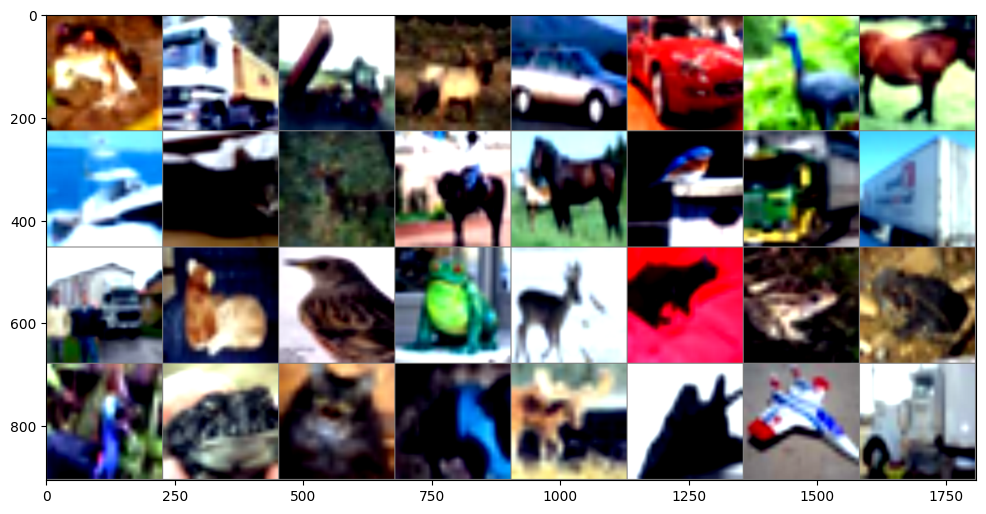

Labels are: tensor([6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6, 4, 3, 6, 6,
        2, 6, 3, 5, 4, 0, 0, 9])
Class names: ['frog', 'truck', 'truck', 'deer', 'car', 'car', 'bird', 'horse', 'ship', 'cat', 'deer', 'horse', 'horse', 'bird', 'truck', 'truck', 'truck', 'cat', 'bird', 'frog', 'deer', 'cat', 'frog', 'frog', 'bird', 'frog', 'cat', 'dog', 'deer', 'plane', 'plane', 'truck']

Showing images with shuffle and augmentation:


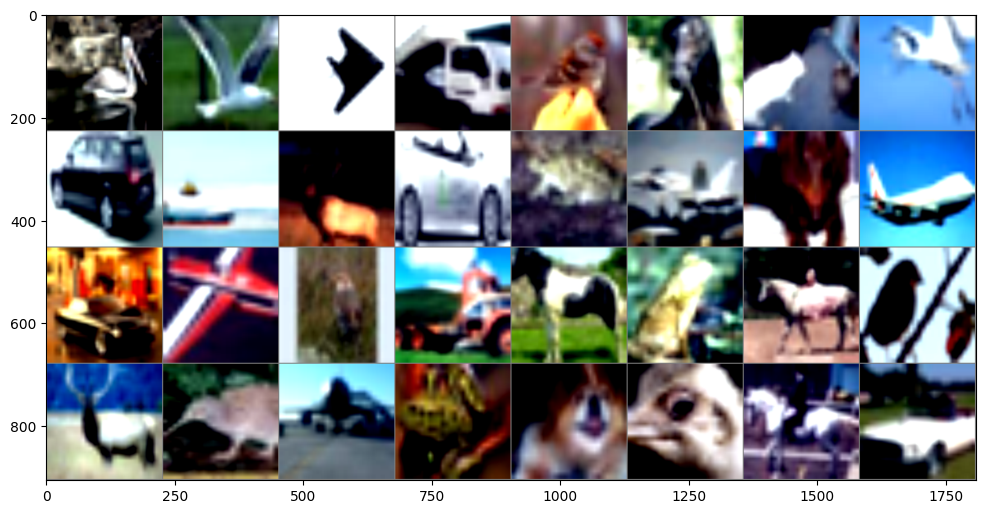

Labels are: tensor([2, 2, 0, 9, 2, 7, 3, 2, 1, 8, 4, 1, 6, 0, 5, 0, 1, 0, 2, 9, 7, 6, 7, 2,
        4, 2, 0, 6, 5, 2, 7, 1])
Class names: ['bird', 'bird', 'plane', 'truck', 'bird', 'horse', 'cat', 'bird', 'car', 'ship', 'deer', 'car', 'frog', 'plane', 'dog', 'plane', 'car', 'plane', 'bird', 'truck', 'horse', 'frog', 'horse', 'bird', 'deer', 'bird', 'plane', 'frog', 'dog', 'bird', 'horse', 'car']


In [49]:
# Define a function to display images
def imshow(img, labels=None, classes=None):
    """
    Display a batch of images with their corresponding labels.

    Parameters:
        img (Tensor): Batch of images in shape (batch_size, channels, height, width).
        labels (Tensor, optional): Corresponding labels for the images.
        classes (list, optional): List of class names to decode labels.
    """
    img = img / 2 + 0.5  # Unnormalize: Convert from [-1, 1] back to [0, 1]
    np_img = img.numpy()
    plt.figure(figsize=(12, 8))
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()
    if labels is not None :
        print(f"Labels are: {labels}")
        if classes is not None:
            class_names = [classes[label] for label in labels]
            print(f"Class names: {class_names}")

# Classes in CIFAR-10
classes = [
    "plane", "car", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

# Create a DataLoader with shuffle=False to see the effect of data augmentation
train_loader = DataLoader(train_set, batch_size=32, shuffle=False)

# Get the first batch of images and labels
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Show the first batch of images with labels
print("Showing images without shuffle (Original Dataset):")
imshow(torchvision.utils.make_grid(images), labels=labels, classes=classes)

# Apply data augmentation and show again
train_loader_aug = DataLoader(train_set, batch_size=32, shuffle=True)
data_iter_aug = iter(train_loader_aug)
aug_images, aug_labels = next(data_iter_aug)

print("\nShowing images with shuffle and augmentation:")
imshow(torchvision.utils.make_grid(aug_images), labels=aug_labels, classes=classes)

# To demonstrate augmentation effects, shuffle and apply augmentation on the dataset.


For trainig our models, we first define some functions to make our job easier. fill the functions according to their signature or you can change them according to your needs.

In [50]:
MODEL_SAVE_PATH = './model.pt'



def fit_epoch(
    model: nn.Module,
    data_loader: DataLoader,
    criterion: nn.Module,
    optimizer: Optimizer,
    train_mode: bool = False
) -> List[float]:
    """
    Runs one epoch of training or validation.

    Args:
        model (nn.Module): The PyTorch model to train or evaluate.
        data_loader (DataLoader): The DataLoader for the dataset.
        criterion (nn.Module): Loss function.
        optimizer (Optimizer): Optimizer for training.
        train_mode (bool): Flag indicating training (True) or validation (False).

    Returns:
        List[float]: List of losses for the epoch.
    """
    if train_mode:
        model.train()
    else:
        model.eval()

    losses = []
    for batch in data_loader:
        images, labels = batch
        images, labels = images.to(device), labels.to(device)

        if train_mode:
            optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        losses.append(loss.item())

        if train_mode:
            loss.backward()
            optimizer.step()

    return losses


# Training function
def train(
    train_loader: DataLoader,
    val_loader: DataLoader,
    model: nn.Module,
    epochs: int,
    lr: float = 1e-3
) -> Tuple[List[float], List[float]]:
    """
    Trains a model and validates it after each epoch.

    Args:
        train_loader (DataLoader): DataLoader for training data.
        val_loader (DataLoader): DataLoader for validation data.
        model (nn.Module): The PyTorch model to train.
        epochs (int): Number of training epochs.
        lr (float): Learning rate for the optimizer.

    Returns:
        Tuple[List[float], List[float]]: Lists of training and validation losses.
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        # Train the model for one epoch
        train_loss = fit_epoch(model, train_loader, criterion, optimizer, train_mode=True)
        train_losses.append(sum(train_loss) / len(train_loss))

        # Validate the model after training
        val_loss = fit_epoch(model, val_loader, criterion, optimizer, train_mode=False)
        val_losses.append(sum(val_loss) / len(val_loss))

        # Print losses
        print(f"Epoch [{epoch+1}/{epochs}] -> "
              f"Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

        # Save model
        torch.save(model.state_dict(), MODEL_SAVE_PATH)

    return train_losses, val_losses


# Calculate accuracy
def get_acc(
    model: nn.Module,
    val_loader: DataLoader
) -> float:
    """
    Calculates accuracy of the model on a validation dataset.

    Args:
        model (nn.Module): The PyTorch model.
        val_loader (DataLoader): DataLoader for validation data.

    Returns:
        float: Validation accuracy.
    """
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return (correct / total)*100


# Plot training and validation losses
def plot_losses(
    train_losses: List[float],
    val_losses: List[float],
    c_window: int = 10
) -> None:
    """
    Plots training and validation losses.

    Args:
        train_losses (List[float]): List of training losses.
        val_losses (List[float]): List of validation losses.
        c_window (int): Convolution window size for smoothing training losses.

    Returns:
        None
    """
    smoothed_train = (
        [sum(train_losses[max(0, i - c_window):i + 1]) / (i - max(0, i - c_window) + 1)
         for i in range(len(train_losses))]
    )

    plt.figure(figsize=(10, 6))
    plt.plot(smoothed_train, label="Train Loss (Smoothed)")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Losses")
    plt.legend()
    plt.grid(True)
    plt.show()


Finally we can start creating the MobileNet model. The architecture is presented here:
![architecture](https://production-media.paperswithcode.com/methods/Screen_Shot_2020-06-22_at_4.26.15_PM_ko4FqXD.png)

You can see the related paper [here](https://arxiv.org/abs/1704.04861)

for cleaner implementation first complete these functions(Each layer consists of a depthwise separable convolution followed by a ReLU activation. The architecture efficiently reduces computations by using depthwise separable convolutions, making it suitable for mobile and embedded applications.):

In [51]:
def conv_bn(inp, oup, stride):
    """
    Defines a standard convolutional layer with batch normalization and ReLU activation.

    Args:
        inp (int): Number of input channels.
        oup (int): Number of output channels.
        stride (int): Stride size for the convolution.

    Returns:
        nn.Sequential: A sequential layer with Conv2D, BatchNorm2D, and ReLU activation.
    """
    return nn.Sequential(
        nn.Conv2d(inp, oup, kernel_size=3, stride=stride, padding=1, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU(inplace=True)
    )


def conv_dw(inp, oup, stride):
    """
    Defines a depthwise separable convolution layer.
    Consists of depthwise convolution followed by pointwise convolution,
    each with batch normalization and ReLU activation.

    Args:
        inp (int): Number of input channels.
        oup (int): Number of output channels.
        stride (int): Stride size for the depthwise convolution.

    Returns:
        nn.Sequential: A sequential layer with Depthwise Conv2D, BatchNorm2D,
                       ReLU, Pointwise Conv2D, BatchNorm2D, and ReLU.
    """
    return nn.Sequential(

        nn.Conv2d(inp, inp, kernel_size=3, stride=stride, padding=1, groups=inp, bias=False),
        nn.BatchNorm2d(inp),
        nn.ReLU(inplace=True),


        nn.Conv2d(inp, oup, kernel_size=1, stride=1, padding=0, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU(inplace=True)
    )


Explain how using Depthwise Separable Convolutions helps us in reducing the number of parameters(calculate and compare number of parameters in normal convolution and depthwise convolution) and how it helps us in making the model faster.


**answer**

Using depthwise separable convolutions drastically reduces the number of parameters and computations compared to standard convolutions, making models faster and more efficient. In a standard convolution, the number of parameters is proportional to the product of the kernel size, the number of input channels (DinDin​), and the number of output channels (DoutDout​). For example, a standard 3×33×3 convolution with Din=32Din​=32 and Dout=64Dout​=64 has 3×3×32×64=18,4323×3×32×64=18,432 parameters. In contrast, a depthwise separable convolution splits this operation into a depthwise convolution, which applies a 3×33×3 filter independently to each input channel (3×3×32=2883×3×32=288 parameters), followed by a pointwise 1×11×1 convolution (32×64=2,04832×64=2,048 parameters). This results in a total of 288+2,048=2,336288+2,048=2,336 parameters, a significant reduction. This smaller parameter count not only reduces the memory footprint but also accelerates computation, as the number of floating-point operations (FLOPs) required decreases. This efficiency makes depthwise separable convolutions ideal for mobile and embedded systems, where computational resources are limited.

Now please create your model.

In [52]:
class MobileNet(nn.Module):
    def __init__(self, n_class=1000):
        super(MobileNet, self).__init__()
        # Define the MobileNet architecture
        self.model = nn.Sequential(
            # Initial standard convolution layer
            conv_bn(3, 32, stride=2),
            # Depthwise separable convolution blocks
            conv_dw(32, 64, stride=1),
            conv_dw(64, 128, stride=2),
            conv_dw(128, 128, stride=1),
            conv_dw(128, 256, stride=2),
            conv_dw(256, 256, stride=1),
            conv_dw(256, 512, stride=2),

            # Repeated depthwise separable convolution blocks (512 -> 512)
            conv_dw(512, 512, stride=1),
            conv_dw(512, 512, stride=1),
            conv_dw(512, 512, stride=1),
            conv_dw(512, 512, stride=1),
            conv_dw(512, 512, stride=1),

            # Final downsampling
            conv_dw(512, 1024, stride=2),
            conv_dw(1024, 1024, stride=1),

            # Global average pooling
            nn.AdaptiveAvgPool2d(1)
        )
        # Fully connected layer for classification
        self.fc = nn.Linear(1024, n_class)

    def forward(self, x):
        x = self.model(x)
        x = x.view(x.size(0), -1)  # Flatten the output from the conv layers
        x = self.fc(x)
        return x




Let's train your model.(You can increase number of epochs or change lr but your accuracy should be above 65 and calculate training time)

In [11]:
epochs = 10
lr = 1e-3
start = time.time()
model = MobileNet(n_class=10)
model = model.to(device)
train_losses, val_losses = train(train_loader, val_loader, model, epochs, lr)
end = time.time()

print('Batch_size={}, epochs={}, lr={}'.format(128, epochs, lr))
print("Process training time: {:0.4f} s".format(end - start))
val_acc = get_acc(model, val_loader)
print('Val accuracy =', val_acc)

Epoch [1/10] -> Train Loss: 1.4551, Val Loss: 1.0851
Epoch [2/10] -> Train Loss: 1.0095, Val Loss: 0.8133
Epoch [3/10] -> Train Loss: 0.8112, Val Loss: 0.6532
Epoch [4/10] -> Train Loss: 0.6885, Val Loss: 0.5789
Epoch [5/10] -> Train Loss: 0.6103, Val Loss: 0.5367
Epoch [6/10] -> Train Loss: 0.5507, Val Loss: 0.4859
Epoch [7/10] -> Train Loss: 0.5025, Val Loss: 0.4481
Epoch [8/10] -> Train Loss: 0.4614, Val Loss: 0.4251
Epoch [9/10] -> Train Loss: 0.4284, Val Loss: 0.4010
Epoch [10/10] -> Train Loss: 0.3970, Val Loss: 0.4176
Batch_size=128, epochs=10, lr=0.001
Process training time: 1844.6672 s
Val accuracy = 0.8626


Get some metrics and plot your losses.

Batch_size=128, epochs=10, lr=0.001
Val accuracy = 0.8626
Process validation time: 25.6443 s


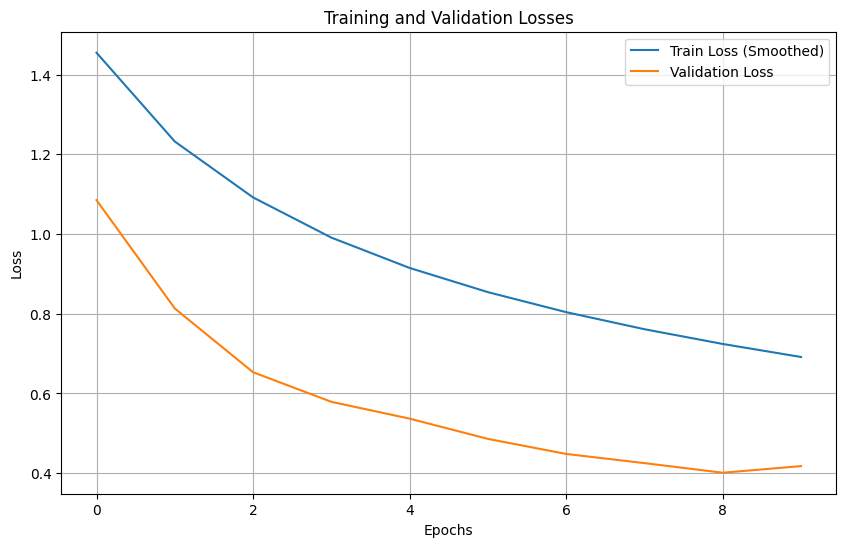

In [12]:
start = time.time()
val_acc = get_acc(model, val_loader)
end = time.time()

print('Batch_size={}, epochs={}, lr={}'.format(128, epochs, lr))
print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))

plot_losses(train_losses, val_losses)

The MobileNet paper claims it is 8 to 9 times faster than standard convolution. Using the theoretical computations of FLOPs for standard convolution and depthwise separable convolution, explain how this number was calculated.


**answer**
The MobileNet paper claims an 8 to 9 times reduction in computational cost compared to standard convolution by using depthwise separable convolution. This speedup is derived from the theoretical reduction in floating-point operations (FLOPs). In standard convolution, the number of operations is proportional to the kernel size squared (K2K2), the number of input channels (DinDin​), and the number of output channels (DoutDout​). Depthwise separable convolution splits this into two steps: a depthwise convolution that applies a K×KK×K filter to each input channel separately, followed by a pointwise 1×11×1 convolution to combine the outputs across channels. This drastically reduces the FLOPs, as the expensive K2×DoutK2×Dout​ term is replaced with a sum of two smaller terms, K2+DoutK2+Dout​. For typical values used in convolutional networks, where the number of output channels (DoutDout​) is much larger than the kernel size squared (K2K2), the computational savings approach 9 times, making MobileNet significantly faster while retaining accuracy.

## 2.Normal CNN
In this part, we will give you a new architecture that is like MobileNet. But this time we will use normal CNN. The model is implemented and you should train it for 2 epochs. So now you can compare its speed in training and validating with your MobileNet.(Note that the accuracy is not important in this part)

In [13]:
class NormalCNN(nn.Module):
    def __init__(self, n_class=1000):
        super().__init__()


        self.model = nn.Sequential(
            conv_bn(  3,  32, 2),
            conv_bn( 32,  64, 1),
            conv_bn( 64, 128, 2),
            conv_bn(128, 128, 1),
            conv_bn(128, 256, 2),
            conv_bn(256, 256, 1),
            conv_bn(256, 512, 2),
            conv_bn(512, 512, 1),
            conv_bn(512, 512, 1),
            conv_bn(512, 512, 1),
            conv_bn(512, 512, 1),
            conv_bn(512, 512, 1),
            conv_bn(512, 1024, 2),
            conv_bn(1024, 1024, 1),
            nn.AvgPool2d(7),
        )
        self.fc = nn.Linear(1024, n_class)

    def forward(self, x):
        x = self.model(x)
        x = x.view(-1, 1024)
        x = self.fc(x)
        return x

In [14]:
#  train model
epochs = 2
lr = 1e-3
model = NormalCNN(n_class=10).to(device)
train_losses, val_losses = train(train_loader, val_loader, model, epochs, lr)

Epoch [1/2] -> Train Loss: 1.8831, Val Loss: 1.6930
Epoch [2/2] -> Train Loss: 1.5268, Val Loss: 1.3521


Batch_size=128, epochs=2, lr=0.001
Val accuracy = 0.5027
Process validation time: 33.1512 s


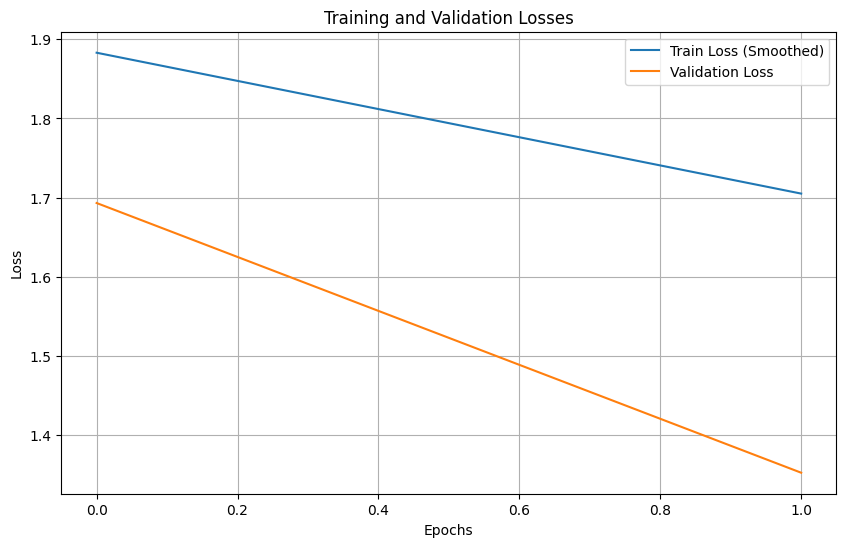

In [15]:
start = time.time()
val_acc = get_acc(model, val_loader)
end = time.time()

print('Batch_size={}, epochs={}, lr={}'.format(128, epochs, lr))
print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))

plot_losses(train_losses, val_losses)

Compare speed of learning and validating in normal CNN vs MobileNet

**answer**
MobileNet significantly outperforms normal CNNs in terms of speed for both training (learning) and validation, primarily due to its use of depthwise separable convolutions. These reduce the computational cost by decomposing standard convolutions into a depthwise convolution and a pointwise 1×11×1 convolution, resulting in 8 to 9 times fewer floating-point operations (FLOPs) compared to standard convolutions. Consequently, MobileNet requires fewer parameters and less memory, making forward and backward passes faster. In training, this means quicker gradient updates and shorter epochs, while during validation, it enables faster inference on large datasets. This speed advantage makes MobileNet particularly suitable for resource-constrained environments, such as mobile devices, without significantly compromising accuracy.

In [16]:
# Function to count the number of parameters in a model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Instantiate the NormalCNN model
normalcnn_model = NormalCNN(n_class=1000).to(device)

# Count parameters in NormalCNN
normalcnn_params = count_parameters(normalcnn_model)
print(f"Total parameters in NormalCNN: {normalcnn_params}")

# Instantiate the MobileNet model (e.g., MobileNetV2)
mobilenet_model = MobileNet(n_class=1000).to(device)

# Count parameters in MobileNet
mobilenet_params = count_parameters(mobilenet_model)
print(f"Total parameters in MobileNet: {mobilenet_params}")

Total parameters in NormalCNN: 29294088
Total parameters in MobileNet: 4231976


## 3.Transfer Learning
Now imagine that you have a well trained model of CIFAR10 and now you want to use transfer learning for a new task of classifying CIFAR100 dataset. in the next cell, you should load your good trained model with an accuracy of 80% on validation data from disk (you should have saved your good model). or use our model (model.pt) and use their parameters for a new model for classifying 100 classes.

In [54]:
# Define your CIFAR100 model
model = MobileNet(n_class=100).to(device)

# Load the pre-trained model
pretrained_model = torch.load('model.pt', map_location=device)

# Determine the structure of the loaded model file
if isinstance(pretrained_model, nn.Module):
    # If the file contains a raw model
    pretrained_dict = pretrained_model.state_dict()
elif isinstance(pretrained_model, dict):
    if 'state_dict' in pretrained_model:
        # If the file is a checkpoint containing a state_dict
        pretrained_dict = pretrained_model['state_dict']
    else:
        # If the file directly contains a state_dict
        pretrained_dict = pretrained_model
else:
    # Raise an error for unsupported formats
    raise ValueError("The loaded model file format is not supported. Inspect the file content.")

# Filter out the weights of the final layer (CIFAR10 -> CIFAR100)
pretrained_dict = {k: v for k, v in pretrained_dict.items() if 'fc' not in k and 'classifier' not in k}

# Get the current model's state_dict
model_dict = model.state_dict()

# Update the current model's state_dict with the pre-trained weights
model_dict.update(pretrained_dict)

# Load the updated state_dict into the model
model.load_state_dict(model_dict)

print("Pre-trained model successfully loaded with transfer learning for CIFAR100")


**Freezing Layers** </br>
To make the best use of transfer learning, you should freeze the initial layers (usually up to the last few convolutional blocks) and only fine-tune the final layers. This way, the model retains most of the learned low-level features from CIFAR-10, while also adapting to CIFAR-100.

In MobileNet, it’s generally effective to freeze layers up to the point where the most complex, high-level features are computed, typically around the 7th or 8th convolutional block.

In [21]:
# Freeze up to the desired layer (e.g., the first 7 layers)
def freeze_layers(model, freeze_up_to=7):
    """
    Freezes layers of the model up to a certain number of layers in the Sequential block.

    Args:
        model (nn.Module): The model to freeze layers in.
        freeze_up_to (int): The number of layers to freeze.
    """
    layer_count = 0  # Counter to track layers
    for layer in model.model:  # Access the Sequential block
        if layer_count < freeze_up_to:
            for param in layer.parameters():
                param.requires_grad = False  # Freeze parameters
            layer_count += 1
        else:
            break
    print(f"Froze the first {layer_count} layers.")

# Instantiate the model
model = MobileNet(n_class=100).to(device)

# Freeze layers up to the 7th block
freeze_layers(model, freeze_up_to=7)

# Verify which layers are frozen
for name, param in model.named_parameters():
    print(f"{name} - requires_grad: {param.requires_grad}")


Froze the first 7 layers.
model.0.0.weight - requires_grad: False
model.0.1.weight - requires_grad: False
model.0.1.bias - requires_grad: False
model.1.0.weight - requires_grad: False
model.1.1.weight - requires_grad: False
model.1.1.bias - requires_grad: False
model.1.3.weight - requires_grad: False
model.1.4.weight - requires_grad: False
model.1.4.bias - requires_grad: False
model.2.0.weight - requires_grad: False
model.2.1.weight - requires_grad: False
model.2.1.bias - requires_grad: False
model.2.3.weight - requires_grad: False
model.2.4.weight - requires_grad: False
model.2.4.bias - requires_grad: False
model.3.0.weight - requires_grad: False
model.3.1.weight - requires_grad: False
model.3.1.bias - requires_grad: False
model.3.3.weight - requires_grad: False
model.3.4.weight - requires_grad: False
model.3.4.bias - requires_grad: False
model.4.0.weight - requires_grad: False
model.4.1.weight - requires_grad: False
model.4.1.bias - requires_grad: False
model.4.3.weight - requires_gr

**Fine-tuning the Model** </br>

With the above setup, you can now train the model on CIFAR-100 using a lower learning rate. A good approach would be to:

Set a slightly lower learning rate (e.g., 1e-4) for the fine-tuning process.

But first get the dataset of CIFAR100.

In [22]:
# TRAIN DATA
train_set100 = torchvision.datasets.CIFAR100(
    root='./data', train=True, download=True, transform=transform_train)

indices = np.arange(20000)
train_set100 = Subset(train_set100, indices)

train_loader100 = torch.utils.data.DataLoader(
    train_set100, batch_size=128, shuffle=True, num_workers=2)

# VALIDATION DATA
val_set100 = torchvision.datasets.CIFAR100(
    root='./data', train=False, download=True, transform=transform_test)

val_loader100 = torch.utils.data.DataLoader(
    val_set100, batch_size=128, shuffle=False, num_workers=2)


100%|██████████| 169M/169M [00:03<00:00, 43.4MB/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


Now show 16 images of your data two times to see the images and how our data augmentaion worked. Also print labels to see the format.

Validation Data Labels:
Labels are: tensor([49, 33, 72, 51, 71, 92, 15, 14, 23, 0, 71, 75, 81, 69, 40, 43, 92, 97, 70, 53, 70, 49, 75, 29, 21, 16, 39, 8, 8, 70, 20, 61, 41, 93, 56, 73, 58, 11, 25, 37, 63, 24, 49, 73, 56, 22, 41, 58, 75, 17, 4, 6, 9, 57, 2, 32, 71, 52, 42, 69, 77, 27, 15, 65, 7, 35, 43, 82, 63, 92, 66, 90, 67, 91, 32, 32, 82, 10, 77, 22, 71, 78, 54, 6, 29, 89, 78, 33, 11, 67, 22, 18, 27, 21, 13, 21, 50, 75, 37, 35, 26, 83, 47, 95, 43, 69, 76, 17, 57, 59, 25, 20, 27, 0, 9, 71, 8, 43, 57, 56, 85, 10, 19, 92, 33, 20, 21, 50])
Labels are: tensor([49, 33, 72, 51, 71, 92, 15, 14, 23, 0, 71, 75, 81, 69, 40, 43, 92, 97, 70, 53, 70, 49, 75, 29, 21, 16, 39, 8, 8, 70, 20, 61, 41, 93, 56, 73, 58, 11, 25, 37, 63, 24, 49, 73, 56, 22, 41, 58, 75, 17, 4, 6, 9, 57, 2, 32, 71, 52, 42, 69, 77, 27, 15, 65, 7, 35, 43, 82, 63, 92, 66, 90, 67, 91, 32, 32, 82, 10, 77, 22, 71, 78, 54, 6, 29, 89, 78, 33, 11, 67, 22, 18, 27, 21, 13, 21, 50, 75, 37, 35, 26, 83, 47, 95, 43, 69, 76, 17, 57, 59, 25, 

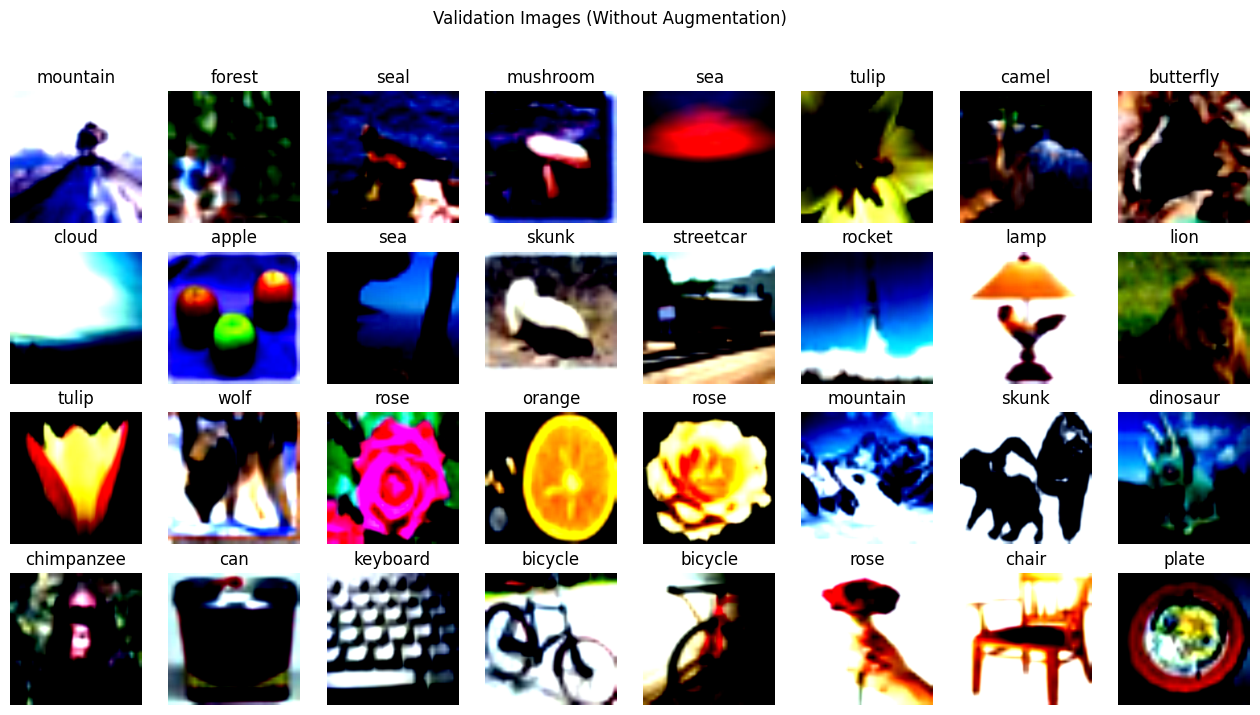

Training Data Labels:
Labels are: tensor([96, 47, 64, 18, 70, 48, 53, 58, 52, 68, 79, 3, 27, 33, 24, 61, 72, 62, 9, 42, 18, 37, 50, 50, 37, 63, 17, 42, 64, 90, 85, 85, 60, 3, 73, 54, 65, 69, 95, 23, 14, 59, 52, 17, 67, 71, 50, 67, 46, 4, 81, 58, 40, 8, 38, 2, 67, 55, 65, 17, 48, 22, 65, 38, 28, 8, 53, 13, 42, 71, 8, 48, 83, 37, 51, 16, 14, 77, 27, 29, 78, 9, 35, 27, 33, 15, 63, 73, 10, 90, 85, 88, 87, 29, 17, 32, 34, 32, 4, 7, 42, 39, 50, 40, 97, 47, 58, 29, 60, 68, 80, 67, 89, 5, 89, 30, 24, 66, 2, 17, 3, 5, 26, 39, 83, 21, 11, 66])
Labels are: tensor([96, 47, 64, 18, 70, 48, 53, 58, 52, 68, 79, 3, 27, 33, 24, 61, 72, 62, 9, 42, 18, 37, 50, 50, 37, 63, 17, 42, 64, 90, 85, 85, 60, 3, 73, 54, 65, 69, 95, 23, 14, 59, 52, 17, 67, 71, 50, 67, 46, 4, 81, 58, 40, 8, 38, 2, 67, 55, 65, 17, 48, 22, 65, 38, 28, 8, 53, 13, 42, 71, 8, 48, 83, 37, 51, 16, 14, 77, 27, 29, 78, 9, 35, 27, 33, 15, 63, 73, 10, 90, 85, 88, 87, 29, 17, 32, 34, 32, 4, 7, 42, 39, 50, 40, 97, 47, 58, 29, 60, 68, 80, 67, 89,

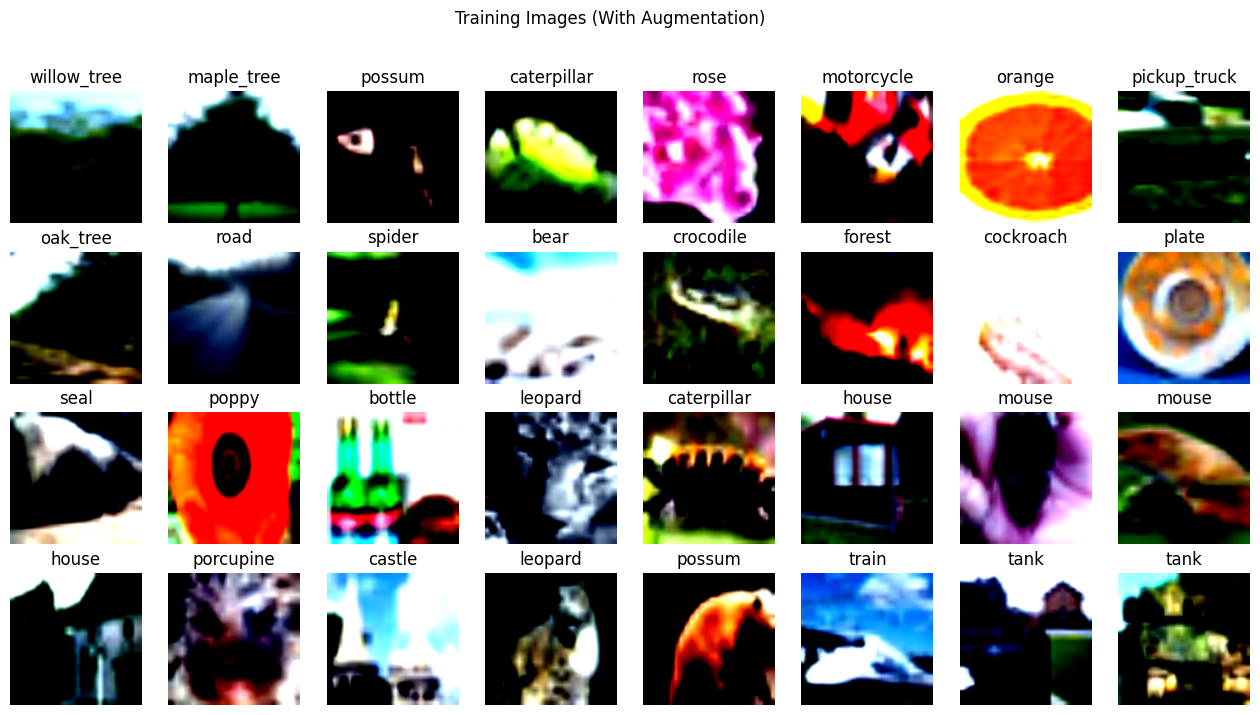

In [23]:
def show_images_with_labels(images, labels, title, class_names):
    # Print the labels as a tensor
    print(f"Labels are: tensor({labels.tolist()})\n")  # Print labels in the desired format

    # Plot the images
    fig, axes = plt.subplots(4, 8, figsize=(16, 8))
    for i, (img, ax) in enumerate(zip(images, axes.flatten())):
        img = img.permute(1, 2, 0).clamp(0, 1)  # Convert CHW to HWC and clip values to [0, 1]
        ax.imshow(img)
        ax.set_title(f"{class_names[labels[i]]}")
        ax.axis('off')
    plt.suptitle(title)
    plt.show()

# CIFAR100 class names
class_names = val_set100.dataset.classes if hasattr(val_set100, 'dataset') else val_set100.classes

# Get a batch of images and labels without augmentation (validation data)
images_no_aug, labels_no_aug = next(iter(val_loader100))

# Get a batch of images and labels with augmentation (training data)
images_aug, labels_aug = next(iter(train_loader100))

# Show images without augmentation and display labels separately
print("Validation Data Labels:")
print(f"Labels are: tensor({labels_no_aug.tolist()})")
show_images_with_labels(images_no_aug, labels_no_aug, title="Validation Images (Without Augmentation)", class_names=class_names)

# Show images with augmentation and display labels separately
print("Training Data Labels:")
print(f"Labels are: tensor({labels_aug.tolist()})")
show_images_with_labels(images_aug, labels_aug, title="Training Images (With Augmentation)", class_names=class_names)


Do CIFAR10 and CIFAR100 use the same images but with diffrent labesl?(maybe you should search)

**answer**
Yes, CIFAR-10 and CIFAR-100 datasets use the same set of 60,000 images, but they differ in how these images are labeled. CIFAR-10 divides the images into 10 broad classes, such as "cat," "dog," and "airplane," with 6,000 images per class. In contrast, CIFAR-100 provides finer granularity by dividing the same images into 100 classes, each containing 600 images. Additionally, CIFAR-100 includes hierarchical labels with "fine" (specific class) and "coarse" (superclass) labels, grouping the 100 classes into 20 superclasses

Now train your model using your functions.

In [24]:
epochs = 7
lr = 2e-4

# Train the model and capture losses
train_losses, val_losses = train(train_loader100, val_loader100, model, epochs, lr)

# Initialize lists to store accuracies
train_accuracies = []
val_accuracies = []

# Calculate accuracies after each epoch
for epoch in range(epochs):
    train_accuracy = get_acc(model, train_loader100)  # Training accuracy
    val_accuracy = get_acc(model, val_loader100)  # Validation accuracy

    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{epochs}] -> "
          f"Train Accuracy: {train_accuracy:.2f}%, Val Accuracy: {val_accuracy:.2f}%")


Epoch [1/7] -> Train Loss: 4.3668, Val Loss: 4.1849
Epoch [2/7] -> Train Loss: 3.9243, Val Loss: 3.8371
Epoch [3/7] -> Train Loss: 3.6974, Val Loss: 3.6822
Epoch [4/7] -> Train Loss: 3.5286, Val Loss: 3.6075
Epoch [5/7] -> Train Loss: 3.3906, Val Loss: 3.5437
Epoch [6/7] -> Train Loss: 3.2795, Val Loss: 3.3525
Epoch [7/7] -> Train Loss: 3.1969, Val Loss: 3.3119
Epoch [1/7] -> Train Accuracy: 0.24%, Val Accuracy: 0.20%
Epoch [2/7] -> Train Accuracy: 0.24%, Val Accuracy: 0.20%
Epoch [3/7] -> Train Accuracy: 0.24%, Val Accuracy: 0.20%
Epoch [4/7] -> Train Accuracy: 0.24%, Val Accuracy: 0.20%
Epoch [5/7] -> Train Accuracy: 0.24%, Val Accuracy: 0.20%
Epoch [6/7] -> Train Accuracy: 0.24%, Val Accuracy: 0.20%
Epoch [7/7] -> Train Accuracy: 0.24%, Val Accuracy: 0.20%


Get some metrics and plot your losses.

Batch_size=128, epochs=7, lr=0.0002
Val accuracy = 0.2045
Process validation time: 19.2801 s


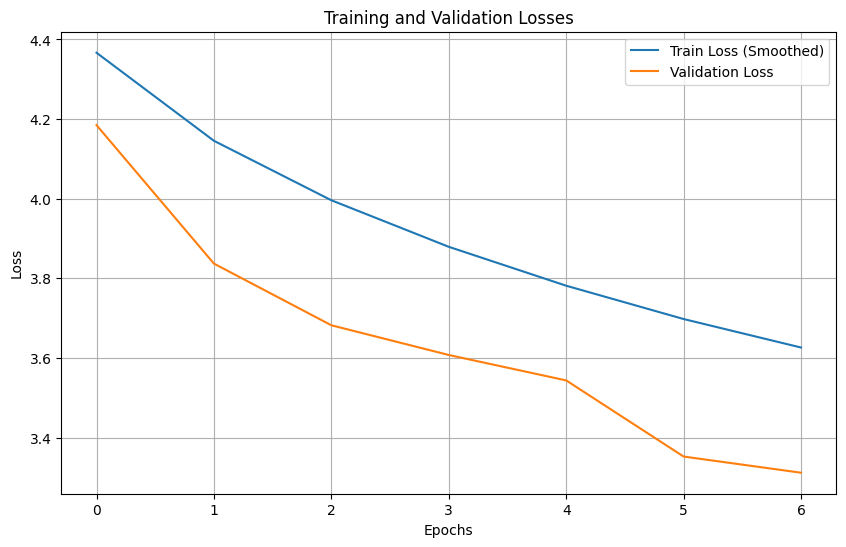

In [27]:
start = time.time()
val_acc = get_acc(model, val_loader100)
end = time.time()

print('Batch_size={}, epochs={}, lr={}'.format(128, epochs, lr))
print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))

plot_losses(train_losses, val_losses)

## 4. MobileNet V2

### Theory
MobileNet V2 builds on the concepts of MobileNet V1, introducing two significant improvements:


- **Inverted Residuals**: One of the most notable features of MobileNet V2 is the use of inverted residual blocks. Unlike traditional residual blocks that connect layers of the same depth, inverted residuals connect layers with different depths, allowing for more efficient information flow and reducing computational complexity.
- **Linear Bottlenecks**: MobileNet V2 introduces linear bottlenecks between the layers. These bottlenecks help preserve the information by maintaining low-dimensional representations, which minimizes information loss and improves the overall accuracy of the model.
- **Depthwise Separable Convolutions**: Similar to MobileNet V1, MobileNet V2 employs depthwise separable convolutions to reduce the number of parameters and computations. This technique splits the convolution into two separate operations: depthwise convolution and pointwise convolution, significantly reducing computational cost.
- **ReLU6 Activation Function**: MobileNet V2 uses the ReLU6 activation function, which clips the ReLU output at 6. This helps prevent numerical instability in low-precision computations, making the model more suitable for mobile and embedded devices.

These innovations enable MobileNet V2 to achieve better accuracy with minimal increase in complexity, making it highly suitable for mobile applications.

You can learn more about MobileNetv2 [here](https://arxiv.org/abs/1801.04381).

One of the paper’s major contributions is the linear bottleneck. In deep learning, especially in low-dimensional spaces, using non-linear layers like ReLU after compressing data can cause important information to be lost. MobileNetV2 addresses this by using linear layers instead of ReLU in the bottleneck stages.


![lb](https://miro.medium.com/v2/resize:fit:720/format:webp/1*YGVXczC3hYtey2z-9MBkPw.png)


Another key innovation in MobileNetV2 is the inverted residual block. Unlike traditional residual blocks (such as those used in ResNet), which expand first and then compress, inverted residuals do the opposite. In MobileNetV2, the input is first compressed and then expanded back to the original dimensions.

![irb](https://miro.medium.com/v2/resize:fit:640/format:webp/1*KyvQcI3Z8AxPpxjLpzrRdg.png)

As shown above, the inverted residual block (b) uses shortcuts, similar to those used in ResNet, but it compresses first and expands second, which makes it more efficient. This “inversion” allows for significant improvements in efficiency by reducing the number of operations required. To maintain performance, shortcuts (or skip connections) are used between the bottleneck layers, ensuring smooth gradient flow during training and preventing the loss of important information.

Now where are going to implement the model. First complete the below functions and class.

What is ReLU6 Activation Function? Why do we use that?

**answer**
ReLU6 is a variation of the Rectified Linear Unit (ReLU) activation function, defined as ReLU6(x)=min⁡(max⁡(0,x),6)ReLU6(x)=min(max(0,x),6), where the output is capped at 6. This means it behaves like the standard ReLU function for positive inputs but saturates at 6 instead of allowing unbounded positive values. ReLU6 is specifically designed for low-precision arithmetic and mobile applications, as its bounded nature helps prevent numerical instabilities when using reduced bit-width representations for weights and activations. By limiting the maximum activation value, it avoids excessive growth in the range of activations, which can otherwise degrade the performance of quantized networks. This makes ReLU6 particularly suitable for resource-constrained environments, such as mobile and embedded devices, where computational efficiency and stability are critical.

In [28]:
# Define helper functions for the convolutions
def conv_bn(inp, oup, stride):
    """
    Standard convolution followed by batch normalization and ReLU6 activation.
    Args:
        inp: Number of input channels.
        oup: Number of output channels.
        stride: Stride for the convolution layer.
    Returns:
        A sequential block of layers.
    """
    return nn.Sequential(
        nn.Conv2d(inp, oup, kernel_size=3, stride=stride, padding=1, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    )

def conv_1x1_bn(inp, oup):
    """
    1x1 pointwise convolution followed by batch normalization and ReLU6 activation.
    Args:
        inp: Number of input channels.
        oup: Number of output channels.
    Returns:
        A sequential block of layers.
    """
    return nn.Sequential(
        nn.Conv2d(inp, oup, kernel_size=1, stride=1, padding=0, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    )

# Define the InvertedResidual block
class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio):
        """
        Inverted Residual block with optional skip connection.
        Args:
            inp: Number of input channels.
            oup: Number of output channels.
            stride: Stride for the depthwise convolution.
            expand_ratio: Multiplier for the hidden dimension size.
        """
        super(InvertedResidual, self).__init__()
        self.stride = stride
        assert stride in [1, 2], "Stride must be 1 or 2."

        hidden_dim = int(inp * expand_ratio)
        self.use_res_connect = (stride == 1 and inp == oup)

        layers = []
        if expand_ratio != 1:
            # Pointwise convolution to expand
            layers.append(conv_1x1_bn(inp, hidden_dim))

        # Depthwise convolution
        layers.extend([
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, stride=stride, padding=1,
                      groups=hidden_dim, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU6(inplace=True)
        ])

        # Pointwise convolution to project back to output channels
        layers.append(nn.Sequential(
            nn.Conv2d(hidden_dim, oup, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(oup)
        ))

        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        """
        Forward pass with optional residual connection.
        Args:
            x: Input tensor.
        Returns:
            Output tensor after applying the block.
        """
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)



Now create the model using the image below. Please note that you should have the width_multiplier hyperparameter in your model. we will use it later.

![architecture](https://i.sstatic.net/1RAkv.png)

In [29]:

class MobileNetV2(nn.Module):
    def __init__(self, n_class=1000, input_size=224, width_multiplier=1.0):
        """
        MobileNetV2 model with width multiplier.

        Args:
            n_class (int): Number of output classes.
            input_size (int): Input image size (assumes square).
            width_multiplier (float): Width multiplier to scale the number of channels.
        """
        super(MobileNetV2, self).__init__()


        interverted_residual_setting = [
            # t (expand ratio), c (channels), n (num blocks), s (stride)
            [1, 16, 1, 1],
            [6, 24, 2, 2],
            [6, 32, 3, 2],
            [6, 64, 4, 2],
            [6, 96, 3, 1],
            [6, 160, 3, 2],
            [6, 320, 1, 1]
        ]

        input_channel = int(32 * width_multiplier)
        last_channel = max(1280, int(1280 * width_multiplier))


        self.features = [conv_bn(3, input_channel, stride=2)]


        for t, c, n, s in interverted_residual_setting:
            output_channel = int(c * width_multiplier)
            for i in range(n):
                stride = s if i == 0 else 1
                self.features.append(
                    InvertedResidual(input_channel, output_channel, stride, expand_ratio=t)
                )
                input_channel = output_channel


        self.features.append(conv_1x1_bn(input_channel, last_channel))
        self.features.append(nn.AdaptiveAvgPool2d(1))


        self.features = nn.Sequential(*self.features)

        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(last_channel, n_class)
        )

    def forward(self, x):
        """
        Forward pass through the model.
        Args:
            x: Input tensor.
        Returns:
            Output tensor (class probabilities or logits).
        """
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


How did you create linear bottlenecks? How do they help?


**answer**
Linear bottlenecks are a key innovation in MobileNetV2. They reduce the dimensionality of features without losing important information by avoiding non-linear activations in the bottleneck layer. This design choice helps MobileNetV2 achieve a balance between accuracy and efficiency, making it ideal for real-time applications on resource-constrained devices.

Train your model with CIFAR10 dataset. Set the width_multiplier with value 1.

In [31]:
model = MobileNetV2(n_class= 10).to(device)
epochs = 10
lr = 1e-3
train_losses, val_losses = train(train_loader, val_loader, model, epochs, lr)
train_accuracies = []
val_accuracies = []

# Calculate accuracies after each epoch
for epoch in range(epochs):
    train_accuracy = get_acc(model, train_loader100)  # Training accuracy
    val_accuracy = get_acc(model, val_loader100)  # Validation accuracy

    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{epochs}] -> "
          f"Train Accuracy: {train_accuracy:.2f}%, Val Accuracy: {val_accuracy:.2f}%")


Epoch [1/10] -> Train Loss: 1.6742, Val Loss: 1.6326
Epoch [2/10] -> Train Loss: 1.3074, Val Loss: 1.1235
Epoch [3/10] -> Train Loss: 1.1189, Val Loss: 1.0900
Epoch [4/10] -> Train Loss: 0.9857, Val Loss: 0.9167
Epoch [5/10] -> Train Loss: 0.8848, Val Loss: 0.8359
Epoch [6/10] -> Train Loss: 0.8017, Val Loss: 0.7256
Epoch [7/10] -> Train Loss: 0.7536, Val Loss: 0.7302
Epoch [8/10] -> Train Loss: 0.7071, Val Loss: 0.6545
Epoch [9/10] -> Train Loss: 0.6736, Val Loss: 0.6515
Epoch [10/10] -> Train Loss: 0.6362, Val Loss: 0.6024
Epoch [1/10] -> Train Accuracy: 0.01%, Val Accuracy: 0.01%
Epoch [2/10] -> Train Accuracy: 0.01%, Val Accuracy: 0.01%
Epoch [3/10] -> Train Accuracy: 0.01%, Val Accuracy: 0.01%
Epoch [4/10] -> Train Accuracy: 0.01%, Val Accuracy: 0.01%
Epoch [5/10] -> Train Accuracy: 0.01%, Val Accuracy: 0.01%
Epoch [6/10] -> Train Accuracy: 0.01%, Val Accuracy: 0.01%
Epoch [7/10] -> Train Accuracy: 0.01%, Val Accuracy: 0.01%
Epoch [8/10] -> Train Accuracy: 0.01%, Val Accuracy: 0.0

Get some metrics and plot your losses.

Batch_size=128, epochs=10, lr=0.001
Val accuracy = 0.7957
Process validation time: 27.8074 s


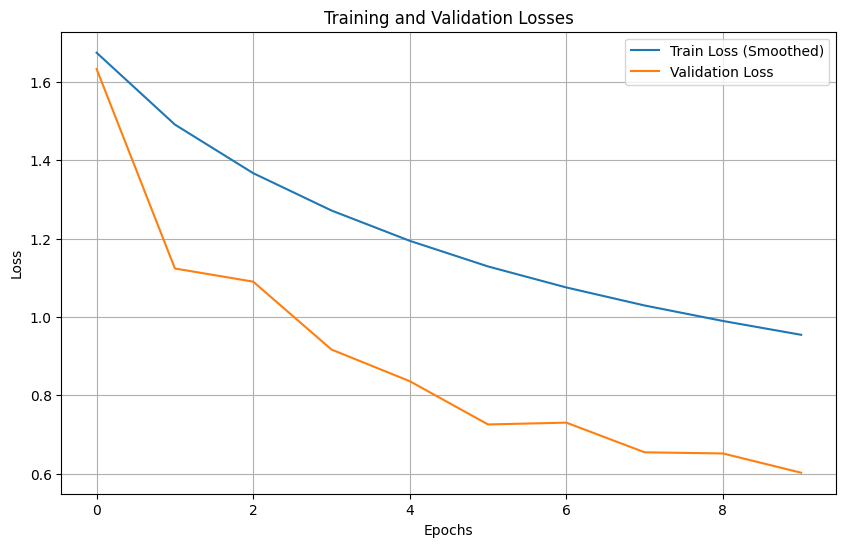

In [33]:
start = time.time()
val_acc = get_acc(model, val_loader)
end = time.time()

print('Batch_size={}, epochs={}, lr={}'.format(128, epochs, lr))
print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))

plot_losses(train_losses, val_losses)

Now we want to see the effect of the hyperparameter (width multiplier) in our model. For all values between 0.1 to 1 with step 0.1 print the number of parameters.

In [34]:
# Function to count the number of parameters in the model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Loop over width multipliers from 0.1 to 1.0 with step 0.1
for width_multiplier in [round(0.1 * i, 1) for i in range(1, 11)]:
    # Create the MobileNetV2 model with the current width multiplier
    model = MobileNetV2(n_class=1000, input_size=224, width_multiplier=width_multiplier)
    # Count the number of trainable parameters
    num_params = count_parameters(model)
    print(f"Width Multiplier: {width_multiplier:.1f}, Number of Parameters: {num_params}")


Width Multiplier: 0.1, Number of Parameters: 1350133
Width Multiplier: 0.2, Number of Parameters: 1451238
Width Multiplier: 0.3, Number of Parameters: 1586634
Width Multiplier: 0.4, Number of Parameters: 1756148
Width Multiplier: 0.5, Number of Parameters: 1965448
Width Multiplier: 0.6, Number of Parameters: 2199581
Width Multiplier: 0.7, Number of Parameters: 2471982
Width Multiplier: 0.8, Number of Parameters: 2778586
Width Multiplier: 0.9, Number of Parameters: 3119396
Width Multiplier: 1.0, Number of Parameters: 3504872


Now load the pretrained model that we trained with width_multiplier=1/2 for 15 epoches. then compare it's accuracy and time it needs for validation data with normal MobileNetv2 model.

In [35]:

model = MobileNetV2(n_class=10, width_multiplier=0.5).to(device)


MNv2_path = './MNv2WMmodel.pt'

checkpoint = torch.load(MNv2_path, map_location= device)

state_dict = checkpoint['state_dict'] if 'state_dict' in checkpoint else checkpoint

model_dict = model.state_dict()
adjusted_state_dict = {}

for key, value in state_dict.items():
    if key in model_dict:
        if value.shape != model_dict[key].shape:
            print(f"Shape mismatch for {key}: {value.shape} (checkpoint) vs {model_dict[key].shape} (model)")
            # Convert [C] -> [C, 1, 3, 3] for convolution weights
            if len(value.shape) == 1 and len(model_dict[key].shape) == 4:
                # Ensure the reshaped size matches the expected size
                expected_elements = torch.prod(torch.tensor(model_dict[key].shape)).item()
                if value.numel() == expected_elements:
                    value = value.view(model_dict[key].shape)
                    print(f"Converted {key}: {value.shape}")
                else:
                    print(f"Skipping {key}: cannot reshape {value.shape} to {model_dict[key].shape}")
                    continue
            else:
                print(f"Skipping {key}: incompatible shapes {value.shape} -> {model_dict[key].shape}")
                continue
        adjusted_state_dict[key] = value

model_dict.update(adjusted_state_dict)
model.load_state_dict(model_dict, strict=False)

print("Model loaded successfully!")


Shape mismatch for features.2.conv.1.weight: torch.Size([48]) (checkpoint) vs torch.Size([48, 1, 3, 3]) (model)
Skipping features.2.conv.1.weight: cannot reshape torch.Size([48]) to torch.Size([48, 1, 3, 3])
Shape mismatch for features.3.conv.1.weight: torch.Size([72]) (checkpoint) vs torch.Size([72, 1, 3, 3]) (model)
Skipping features.3.conv.1.weight: cannot reshape torch.Size([72]) to torch.Size([72, 1, 3, 3])
Shape mismatch for features.4.conv.1.weight: torch.Size([72]) (checkpoint) vs torch.Size([72, 1, 3, 3]) (model)
Skipping features.4.conv.1.weight: cannot reshape torch.Size([72]) to torch.Size([72, 1, 3, 3])
Shape mismatch for features.5.conv.1.weight: torch.Size([96]) (checkpoint) vs torch.Size([96, 1, 3, 3]) (model)
Skipping features.5.conv.1.weight: cannot reshape torch.Size([96]) to torch.Size([96, 1, 3, 3])
Shape mismatch for features.6.conv.1.weight: torch.Size([96]) (checkpoint) vs torch.Size([96, 1, 3, 3]) (model)
Skipping features.6.conv.1.weight: cannot reshape torch.

<ipython-input-35-2bc6cd7b0dc8>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(MNv2_path, map_location= device)


In [36]:
start = time.time()
val_acc = get_acc(model, val_loader)
end = time.time()

print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))



Val accuracy = 0.1
Process validation time: 24.2527 s


Explain how this hyperparameter changes the number of parameters in theory. Write a formula to predict its effect without actually creating the models. Compare your formula with the above numbers and if they dont match perfectly explain a bit.
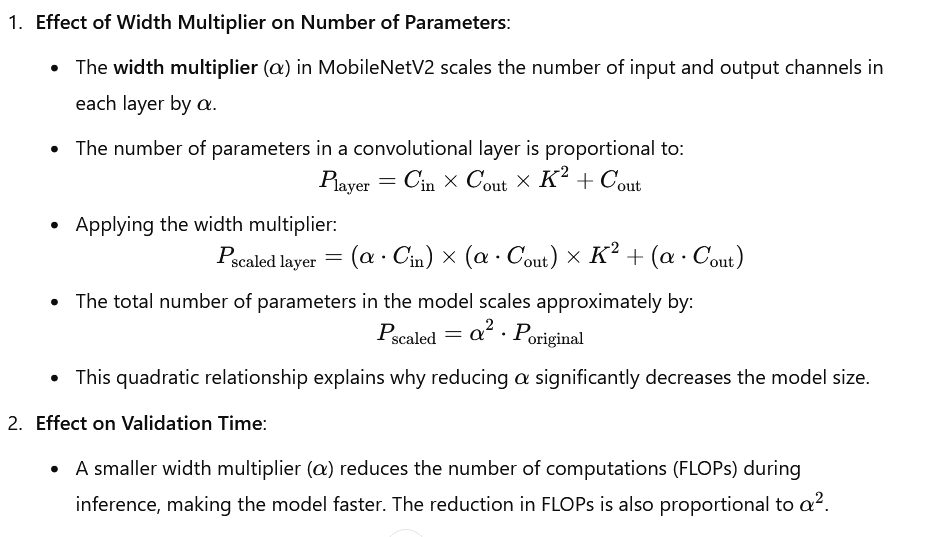

**answer**

Another hyperparameter is resolution multiplier. Can it make our model faster? Does it decrease the number of parameters? Explain.
The resolution multiplier in MobileNetV2 scales the input image dimensions, directly reducing the spatial size of feature maps processed by the network. This makes the model faster by lowering the computational cost, which decreases approximately by the square of the multiplier (ρ2ρ2). However, it does not affect the number of parameters, as these depend only on the network's architecture (e.g., channels and kernel size) and are independent of input resolution. While a lower resolution can significantly speed up inference, it may also reduce accuracy due to the loss of spatial detail in the input image.

**answer**

Why is the number of parameters important for us? Now we have GPUs that can increase performance considerably. Is the number of parameters really a big deal?
The number of parameters is important because it directly affects a model's memory usage, computational cost, and energy efficiency, especially during deployment on resource-constrained devices like mobile phones or embedded systems. While modern GPUs can handle large models efficiently during training, having too many parameters can lead to longer inference times, higher energy consumption, and potential overfitting. In practical scenarios, optimizing the number of parameters is crucial for balancing performance, efficiency, and scalability across diverse hardware environments.

**answer**

## 5.Knowledge Distillation

Now we learn how you can implement knowledge distillation using a pre-trained ResNet as the teacher model and MobileNetV2 as the student model for the CIFAR-10 dataset.

Knowledge distillation is a process where a smaller, more efficient model (the student) is trained to replicate the behavior of a larger, more complex model (the teacher). This is particularly useful for deploying models on resource-constrained devices where efficiency and speed are critical.

You can learn more about the loss function we use for this porpuse [here](
https://medium.com/@aryamaanthakur/knowledge-distillation-make-your-neural-networks-smaller-398485f811c6)

First create our teacher.(Pay attention that we need to finetune this teacher for out task, but because of lack of resources we will just use it with terrible accuracy)

In [37]:
import timm

# Load a pre-trained ResNet18 fine-tuned on CIFAR-10
teacher_model = timm.create_model('resnet18', pretrained=True, num_classes=10)
teacher_model = teacher_model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

In [38]:
start = time.time()
val_acc = get_acc(teacher_model, val_loader)
end = time.time()

print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))


Val accuracy = 0.1149
Process validation time: 28.1041 s


Now create a mobilenetv2 model and then write the code to train it with Knowledge Distillation.

In [39]:

class DistillationLoss(nn.Module):
    """
    Custom loss function for knowledge distillation combining KL divergence
    and cross-entropy loss.

    Args:
        temperature (float): Temperature parameter for scaling logits.
        alpha (float): Weighting factor for distillation and classification loss.
    """
    def __init__(self, temperature: float = 3.0, alpha: float = 0.5):
        super(DistillationLoss, self).__init__()
        self.temperature = temperature
        self.alpha = alpha
        self.criterion = nn.CrossEntropyLoss()

    def forward(self,
                student_logits: torch.Tensor,
                teacher_logits: torch.Tensor,
                labels: torch.Tensor) -> torch.Tensor:
        """
        Compute the combined distillation and classification loss.

        Args:
            student_logits (torch.Tensor): Logits from the student model.
            teacher_logits (torch.Tensor): Logits from the teacher model.
            labels (torch.Tensor): Ground truth labels.

        Returns:
            torch.Tensor: The computed loss value.
        """
        # Soft targets with temperature scaling
        teacher_probs = torch.nn.functional.softmax(teacher_logits / self.temperature, dim=1)
        student_log_probs = torch.nn.functional.log_softmax(student_logits / self.temperature, dim=1)

        # Distillation loss (KL divergence)
        distillation_loss = nn.KLDivLoss(reduction='batchmean')(student_log_probs, teacher_probs)

        # Cross-entropy loss (hard targets)
        classification_loss = self.criterion(student_logits, labels)

        # Combined loss (alpha balances the two)
        return self.alpha * distillation_loss + (1 - self.alpha) * classification_loss


def train_student(teacher: nn.Module,
                  student: nn.Module,
                  train_loader: torch.utils.data.DataLoader,
                  test_loader: torch.utils.data.DataLoader,
                  device: torch.device,
                  epochs: int = 10,
                  lr: float = 0.01) -> None:
    """
    Train a student model using knowledge distillation.

    Args:
        teacher (nn.Module): Pre-trained teacher model.
        student (nn.Module): Student model to train.
        train_loader (torch.utils.data.DataLoader): DataLoader for training data.
        test_loader (torch.utils.data.DataLoader): DataLoader for test data.
        device (torch.device): Device to perform training on (CPU or GPU).
        epochs (int): Number of training epochs. Default is 10.
        lr (float): Learning rate for the optimizer. Default is 0.01.
    """
    teacher.to(device).eval()  # Teacher in evaluation mode (no gradients)
    student.to(device)  # Student in training mode

    criterion = DistillationLoss(temperature=3.0, alpha=0.5)
    optimizer = optim.Adam(student.parameters(), lr=lr)

    for epoch in range(epochs):
        student.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass for the student
            student_outputs = student(images)

            # Forward pass for the teacher (no gradients)
            with torch.no_grad():
                teacher_outputs = teacher(images)

            # Compute loss
            loss = criterion(student_outputs, teacher_outputs, labels)

            # Backpropagation and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(student_outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total * 100
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')

        # Validation
        val_acc = get_acc(student, test_loader, device)
        print(f'Validation Accuracy: {val_acc:.2f}%')

def get_acc(model, data_loader, device):
    """
    Calculate the accuracy of the model on the given dataset.

    Args:
        model (nn.Module): The model to evaluate.
        data_loader (torch.utils.data.DataLoader): DataLoader for the dataset.
        device (torch.device): Device to perform evaluation on (CPU or GPU).

    Returns:
        float: The accuracy of the model on the dataset.
    """
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total


Train it for one epoch to just check if it works.

In [40]:
student = MobileNetV2(n_class=10)

train_student(teacher_model, student, train_loader, val_loader, device, epochs=1, lr=0.001)

Epoch [1/1], Loss: 0.8740, Accuracy: 39.03%
Validation Accuracy: 51.41%


What are the potential trade-offs of using a high value of alpha (e.g., 0.9) versus a low value of alpha (e.g., 0.1) in the DistillationLoss? How might these trade-offs impact the student model's performance in terms of generalization to the target task and alignment with the teacher's knowledge?


**answer**

## Summary
- **MobileNet V1**: Introduced depthwise separable convolutions, significantly reducing computation and model size.
- **MobileNet V2**: Added inverted residuals and linear bottlenecks to improve efficiency and performance, reducing memory use without sacrificing accuracy.

These architectures are optimized for mobile and embedded applications, providing a balance between accuracy and efficiency through lightweight, effective design.

question for yourself: What new features and innovations did MobileNetV3 introduce to improve both efficiency and accuracy over its predecessors? Explore its design choices and how they further optimize MobileNet for real-time applications and mobile deployment.

## Refrences

[1] Andrew G. Howard, Menglong Zhu, Bo Chen,
Dmitry Kalenichenko, Weijun Wang, Tobias
Weyand, Marco Andreetto, and Hartwig Adam. Mobilenets: Efficient convolutional neural networks for mobile vision applications. CoRR,
abs/1704.04861, 2017

[2] Mark Sandler, Andrew G. Howard, Menglong Zhu, Andrey
Zhmoginov, and Liang-Chieh Chen. Mobilenetv2: Inverted
residuals and linear bottlenecks. mobile networks for classification, detection and segmentation. CoRR, abs/1801.04381,
2018